In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score


# Set display options for pandas DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
# Load the datasets
df_att = pd.read_csv("scoutium_attributes.csv", sep=';')
df_lab = pd.read_csv("scoutium_potential_labels.csv", sep=';')

In [4]:
# Merge the datasets on common identifiers
merged_df = pd.merge(df_att, df_lab, on=("task_response_id", "match_id", "evaluator_id", "player_id"), how='inner')

In [5]:
# Remove goalkeepers (position_id == 1) from the dataset
new_df = merged_df[~(merged_df["position_id"] == 1)]
new_df.head()

# Check if goalkeepers are removed
print((new_df["position_id"] == 1).sum())

0


In [6]:
# Display the number of rows before and after removing goalkeepers
print(len(merged_df))
print(len(new_df))

10730
10030


In [7]:
# Analyze the distribution of the target variable 'potential_label'
print(new_df["potential_label"].value_counts() / 100)

potential_label
average         79.22000
highlighted     19.72000
below_average    1.36000
Name: count, dtype: float64


In [8]:
# Remove players with 'below_average' label from the dataset
new_df = new_df[~(new_df["potential_label"] == "below_average")]
new_df["potential_label"].unique()

array(['average', 'highlighted'], dtype=object)

In [9]:
# Create a pivot table to reshape the data for modeling
pt = pd.pivot_table(new_df, values="attribute_value", columns="attribute_id", index=["player_id", "position_id", "potential_label"])
pt = pt.reset_index(drop=False)

In [10]:
# Convert column names to strings
pt.columns = pt.columns.map(str)

In [11]:
# Define numerical columns (attributes) for analysis
num_cols = pt.columns[3:]

In [12]:
# Create a new feature 'mentality' based on player position
pt["mentality"] = pt["position_id"].apply(lambda x: "defender" if x in [2, 3, 4, 5] else "attacker")

In [13]:
# Calculate basic statistics for each player
pt["min"] = pt[num_cols].min(axis=1)
pt["max"] = pt[num_cols].max(axis=1)
pt["sum"] = pt[num_cols].sum(axis=1)
pt["mean"] = pt[num_cols].mean(axis=1)
pt["median"] = pt[num_cols].median(axis=1)

In [14]:
# Display the first few rows of the processed dataset
pt.head()

attribute_id,player_id,position_id,potential_label,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426,mentality,min,max,sum,mean,median
0,1355710,7,average,50.50000,50.50000,34.00000,50.50000,45.00000,45.00000,45.00000,45.00000,50.50000,56.00000,39.50000,34.00000,39.50000,39.50000,45.00000,45.00000,50.50000,28.50000,23.00000,39.50000,28.50000,28.50000,45.00000,50.50000,56.00000,34.00000,39.50000,50.50000,34.00000,34.00000,56.00000,34.00000,34.00000,56.00000,attacker,23.00000,56.00000,1436.50000,42.25000,45.00000
1,1356362,9,average,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,56.00000,67.00000,67.00000,56.00000,67.00000,67.00000,67.00000,67.00000,78.00000,67.00000,67.00000,67.00000,67.00000,67.00000,56.00000,78.00000,attacker,56.00000,78.00000,2267.00000,66.67647,67.00000
2,1356375,3,average,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,67.00000,78.00000,67.00000,67.00000,78.00000,56.00000,67.00000,67.00000,67.00000,67.00000,67.00000,56.00000,56.00000,67.00000,67.00000,56.00000,56.00000,67.00000,67.00000,67.00000,78.00000,67.00000,67.00000,67.00000,67.00000,67.00000,56.00000,78.00000,defender,56.00000,78.00000,2256.00000,66.35294,67.00000
3,1356375,4,average,67.00000,78.00000,67.00000,67.00000,67.00000,78.00000,78.00000,78.00000,56.00000,67.00000,67.00000,67.00000,78.00000,78.00000,56.00000,67.00000,67.00000,45.00000,45.00000,56.00000,67.00000,67.00000,67.00000,67.00000,78.00000,67.00000,67.00000,67.00000,56.00000,67.00000,56.00000,67.00000,45.00000,56.00000,defender,45.00000,78.00000,2223.00000,65.38235,67.00000
4,1356411,9,average,67.00000,67.00000,78.00000,78.00000,67.00000,67.00000,67.00000,67.00000,89.00000,78.00000,67.00000,67.00000,67.00000,56.00000,56.00000,67.00000,78.00000,56.00000,56.00000,67.00000,56.00000,67.00000,56.00000,67.00000,67.00000,56.00000,67.00000,67.00000,56.00000,67.00000,89.00000,56.00000,67.00000,78.00000,attacker,56.00000,89.00000,2278.00000,67.00000,67.00000


In [15]:
# Define a function to summarize the dataset
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())

check_df(pt)

##################### Shape #####################
(271, 43)
##################### Types #####################
attribute_id
player_id            int64
position_id          int64
potential_label     object
4322               float64
4323               float64
4324               float64
4325               float64
4326               float64
4327               float64
4328               float64
4329               float64
4330               float64
4332               float64
4333               float64
4335               float64
4338               float64
4339               float64
4340               float64
4341               float64
4342               float64
4343               float64
4344               float64
4345               float64
4348               float64
4349               float64
4350               float64
4351               float64
4352               float64
4353               float64
4354               float64
4355               float64
4356               float64
4357         

In [16]:
# Define a function to summarize categorical variables
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

# Summarize position and potential label columns
for col in ["position_id", "potential_label"]:
    cat_summary(pt, col)

             position_id    Ratio
position_id                      
2                     53 19.55720
6                     41 15.12915
10                    29 10.70111
7                     28 10.33210
3                     26  9.59410
8                     25  9.22509
4                     24  8.85609
5                     23  8.48708
9                     22  8.11808
##########################################
                 potential_label    Ratio
potential_label                          
average                      215 79.33579
highlighted                   56 20.66421
##########################################


count   271.00000
mean     58.36777
std      14.52679
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      56.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4322, dtype: float64


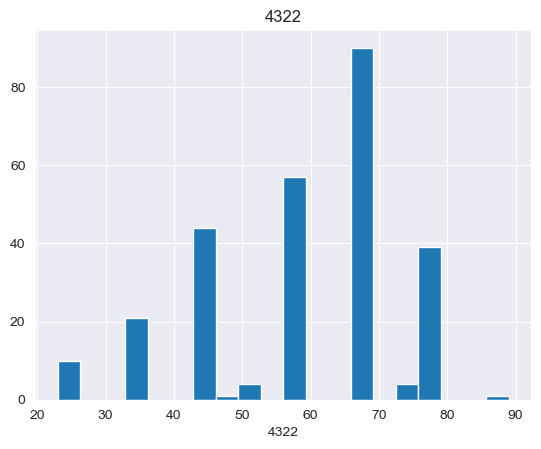

count   271.00000
mean     58.73985
std      14.75710
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      72.50000
90%      78.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4323, dtype: float64


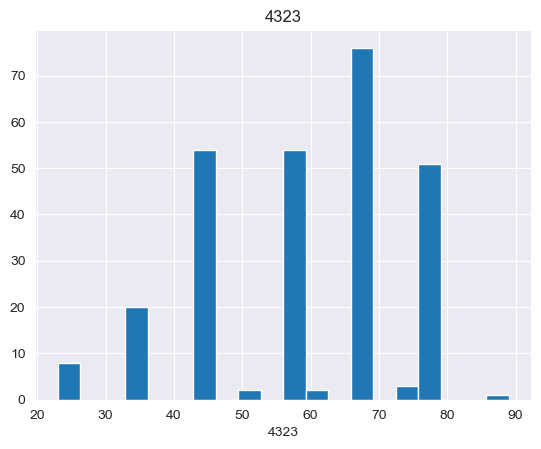

count   271.00000
mean     56.25031
std      15.86849
min      23.00000
5%       34.00000
10%      34.00000
20%      34.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      78.00000
Name: 4324, dtype: float64


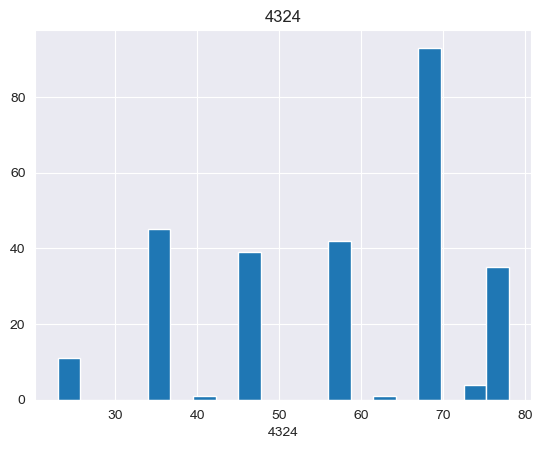

count   271.00000
mean     56.94711
std      14.74947
min      12.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      61.50000
60%      67.00000
70%      67.00000
80%      67.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4325, dtype: float64


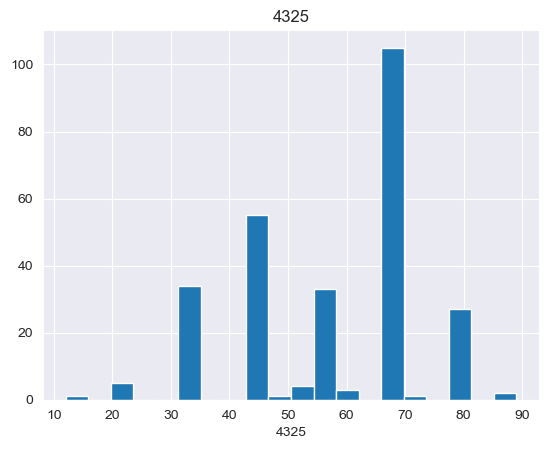

count   271.00000
mean     56.32472
std      14.79995
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      61.50000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4326, dtype: float64


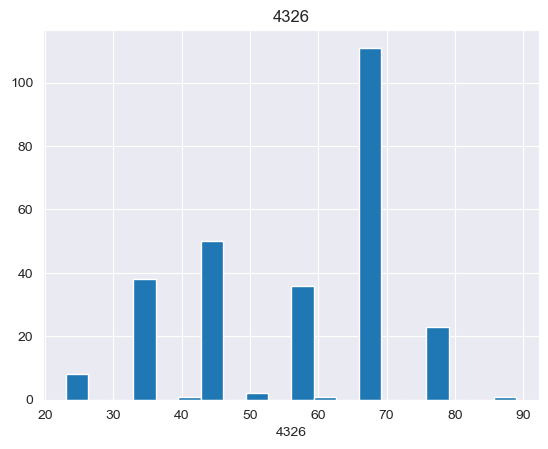

count   271.00000
mean     56.52091
std      14.52214
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      78.00000
Name: 4327, dtype: float64


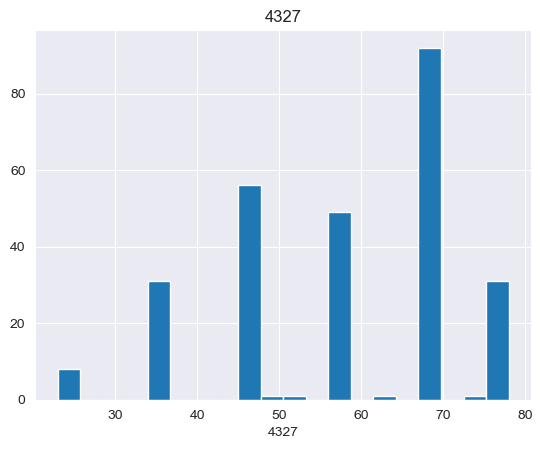

count   271.00000
mean     58.23247
std      14.61061
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4328, dtype: float64


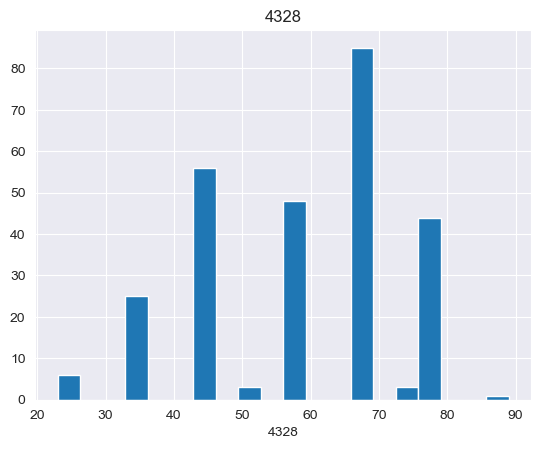

count   271.00000
mean     59.56519
std      18.43361
min      12.00000
5%       23.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      67.00000
60%      67.00000
70%      78.00000
80%      78.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4329, dtype: float64


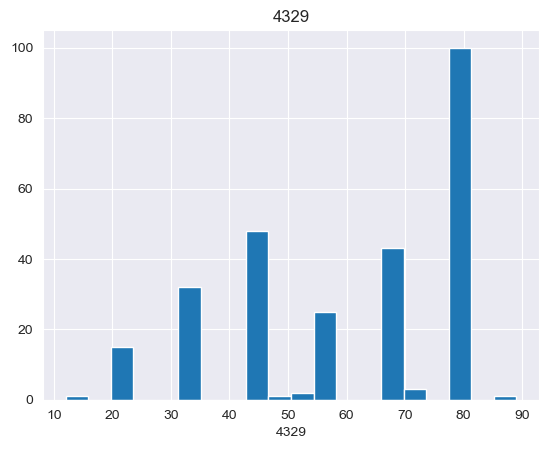

count   271.00000
mean     56.77122
std      14.07682
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      56.00000
40%      56.00000
50%      61.50000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      72.50000
99%      78.00000
max      89.00000
Name: 4330, dtype: float64


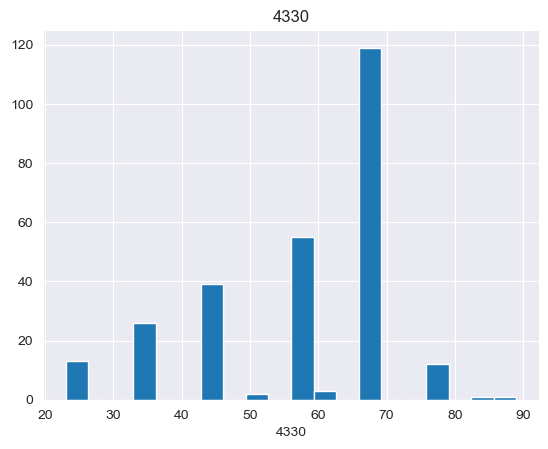

count   271.00000
mean     57.65744
std      13.54201
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      56.00000
40%      56.00000
50%      61.50000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4332, dtype: float64


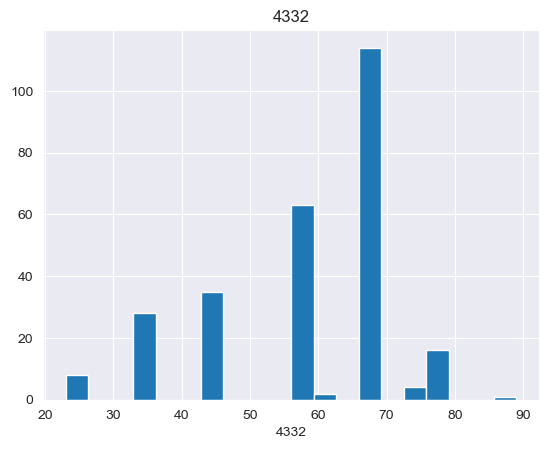

count   271.00000
mean     59.49754
std      16.36998
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      56.00000
40%      56.00000
50%      67.00000
60%      67.00000
70%      72.50000
80%      78.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      78.00000
Name: 4333, dtype: float64


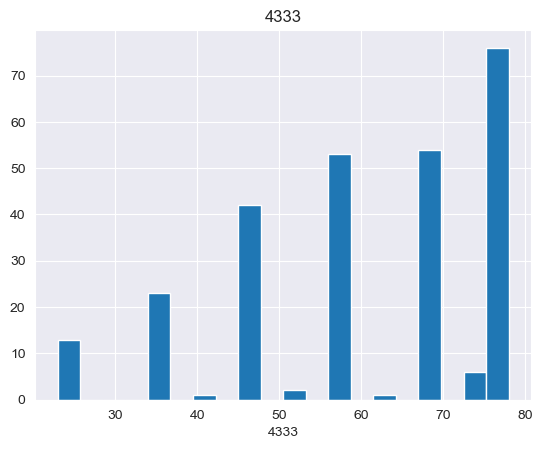

count   271.00000
mean     50.81796
std      16.26935
min      12.00000
5%       23.00000
10%      34.00000
20%      34.00000
30%      34.00000
40%      45.00000
50%      56.00000
60%      56.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      67.00000
99%      78.00000
max      89.00000
Name: 4335, dtype: float64


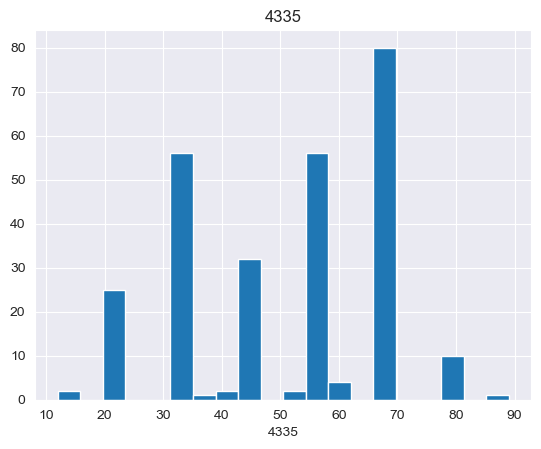

count   271.00000
mean     57.11624
std      15.67058
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      78.00000
Name: 4338, dtype: float64


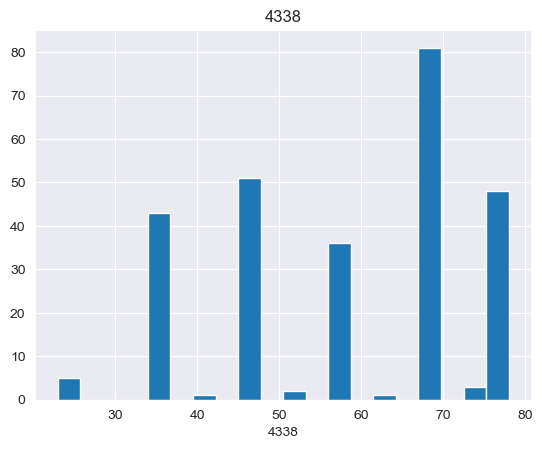

count   271.00000
mean     54.50492
std      14.89439
min      23.00000
5%       28.50000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4339, dtype: float64


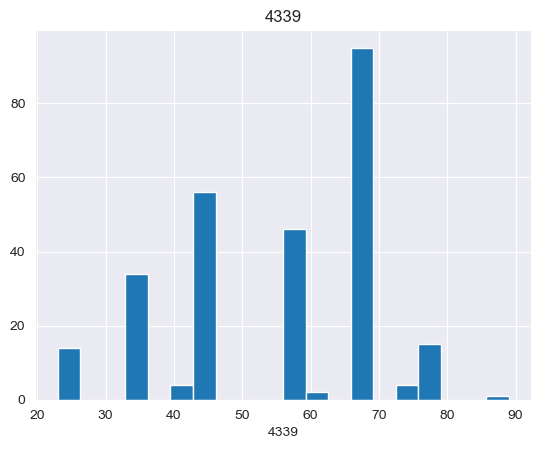

count   271.00000
mean     53.19926
std      15.16144
min      12.00000
5%       23.00000
10%      34.00000
20%      34.00000
30%      45.00000
40%      45.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      67.00000
99%      78.00000
max      78.00000
Name: 4340, dtype: float64


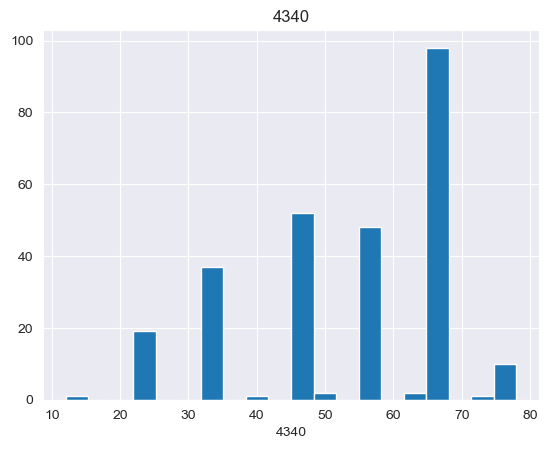

count   271.00000
mean     55.19496
std      14.79459
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4341, dtype: float64


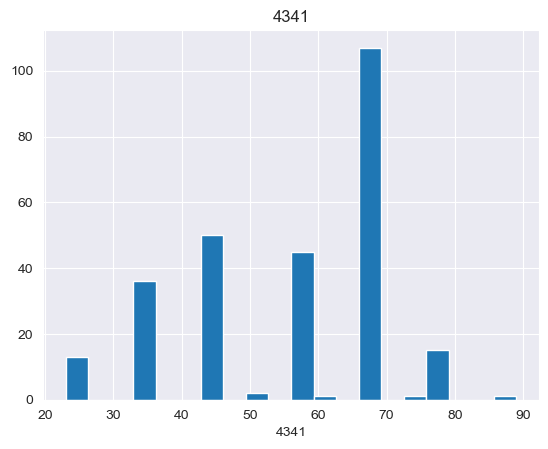

count   271.00000
mean     58.36101
std      14.71816
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      67.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4342, dtype: float64


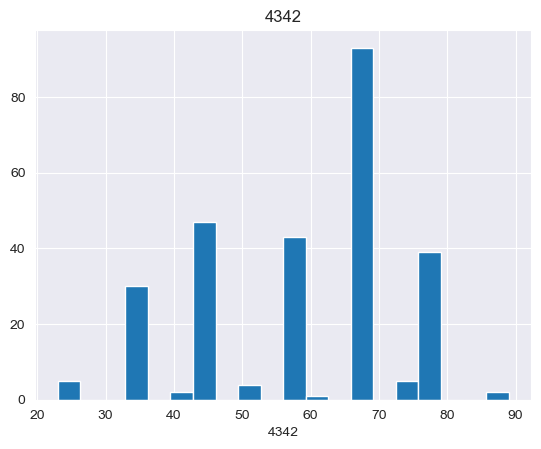

count   271.00000
mean     46.38684
std      16.79015
min      12.00000
5%       23.00000
10%      23.00000
20%      23.00000
30%      34.00000
40%      45.00000
50%      45.00000
60%      56.00000
70%      56.00000
80%      67.00000
90%      67.00000
95%      67.00000
99%      74.15000
max      89.00000
Name: 4343, dtype: float64


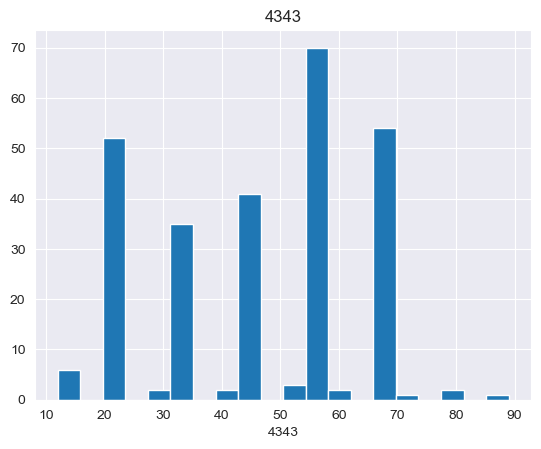

count   271.00000
mean     43.34932
std      16.90924
min      12.00000
5%       23.00000
10%      23.00000
20%      23.00000
30%      34.00000
40%      34.00000
50%      45.00000
60%      56.00000
70%      56.00000
80%      56.00000
90%      56.00000
95%      67.00000
99%      78.00000
max     100.00000
Name: 4344, dtype: float64


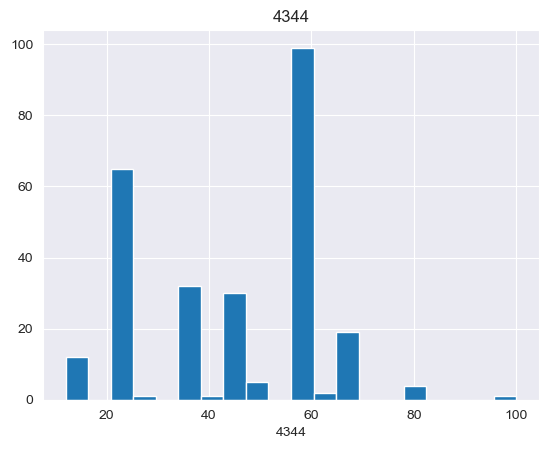

count   271.00000
mean     55.31673
std      15.76831
min      23.00000
5%       28.50000
10%      34.00000
20%      34.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      78.00000
99%      78.00000
max      83.50000
Name: 4345, dtype: float64


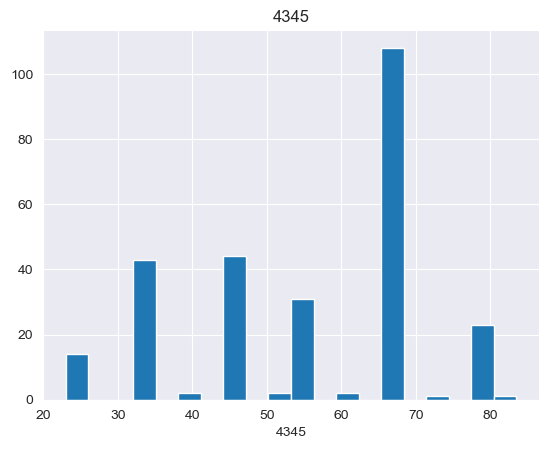

count   271.00000
mean     51.56888
std      17.59175
min      12.00000
5%       23.00000
10%      23.00000
20%      34.00000
30%      34.00000
40%      45.00000
50%      56.00000
60%      61.50000
70%      67.00000
80%      67.00000
90%      67.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4348, dtype: float64


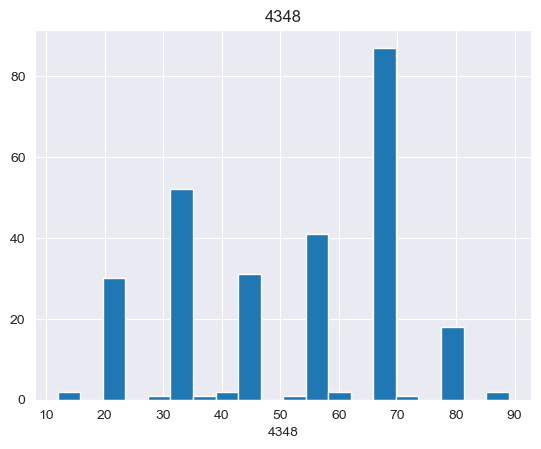

count   271.00000
mean     45.23678
std      16.09536
min      12.00000
5%       23.00000
10%      23.00000
20%      23.00000
30%      34.00000
40%      45.00000
50%      45.00000
60%      56.00000
70%      56.00000
80%      56.00000
90%      67.00000
95%      67.00000
99%      78.00000
max      89.00000
Name: 4349, dtype: float64


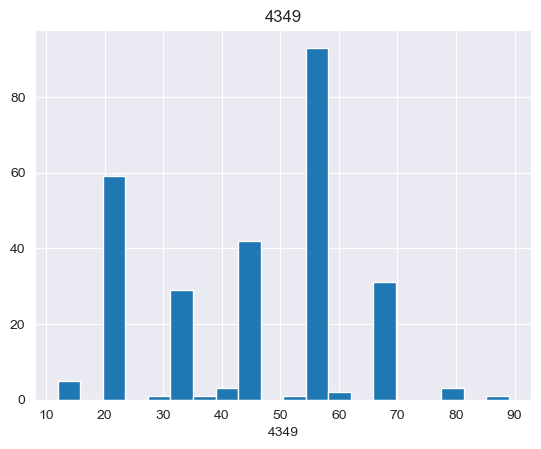

count   271.00000
mean     54.89729
std      14.30268
min      12.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      67.00000
99%      78.00000
max      78.00000
Name: 4350, dtype: float64


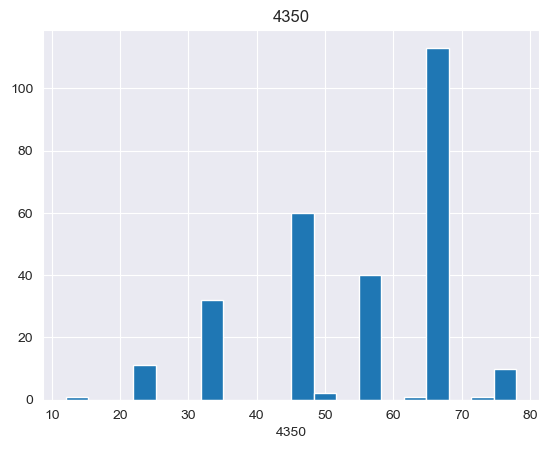

count   271.00000
mean     56.73739
std      14.34448
min      12.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      78.00000
99%      78.00000
max     100.00000
Name: 4351, dtype: float64


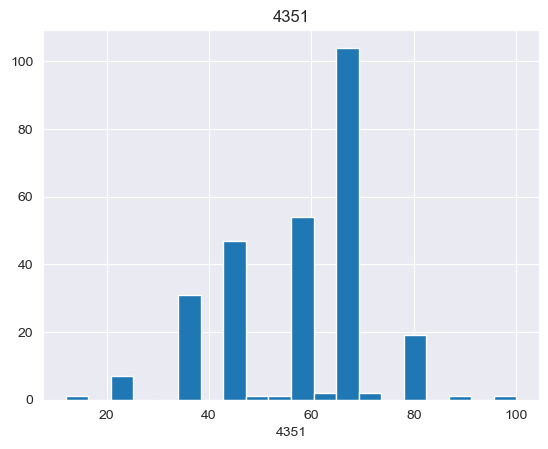

count   271.00000
mean     55.81734
std      14.24309
min      12.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      67.00000
99%      78.00000
max      78.00000
Name: 4352, dtype: float64


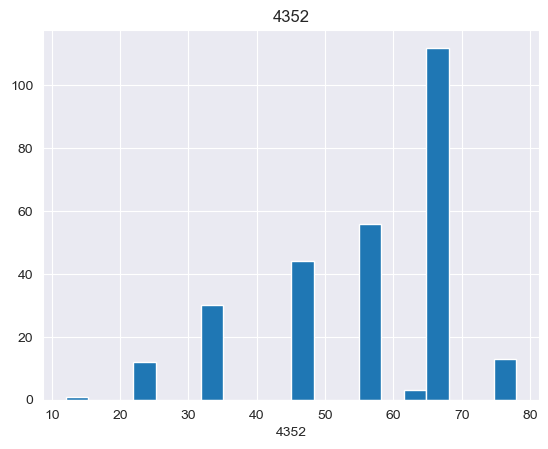

count   271.00000
mean     54.18696
std      15.77684
min      12.00000
5%       34.00000
10%      34.00000
20%      34.00000
30%      45.00000
40%      45.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      78.00000
99%      78.00000
max      78.00000
Name: 4353, dtype: float64


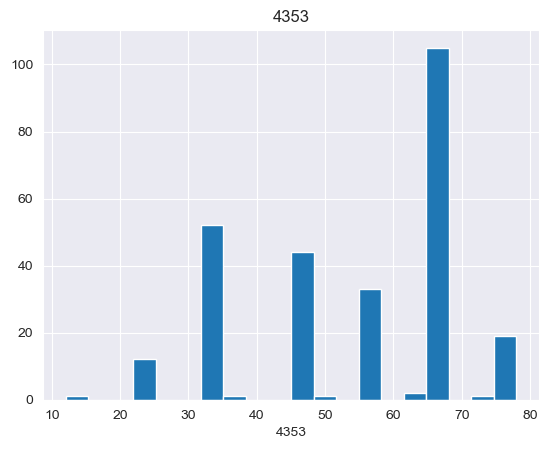

count   271.00000
mean     59.45018
std      17.65262
min      12.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      78.00000
80%      78.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      78.00000
Name: 4354, dtype: float64


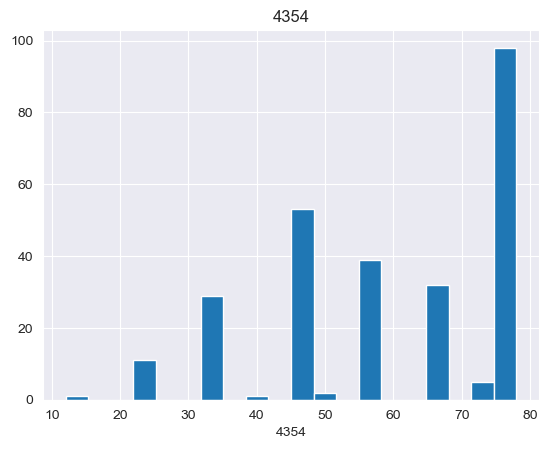

count   271.00000
mean     57.74539
std      14.67701
min      12.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4355, dtype: float64


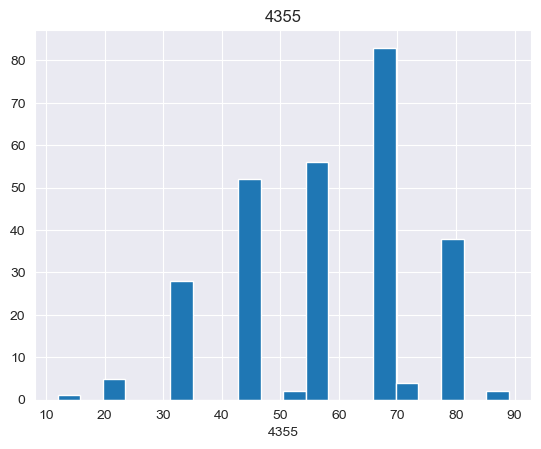

count   271.00000
mean     52.95572
std      15.37879
min      23.00000
5%       23.00000
10%      34.00000
20%      34.00000
30%      45.00000
40%      45.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      67.00000
99%      78.00000
max      78.00000
Name: 4356, dtype: float64


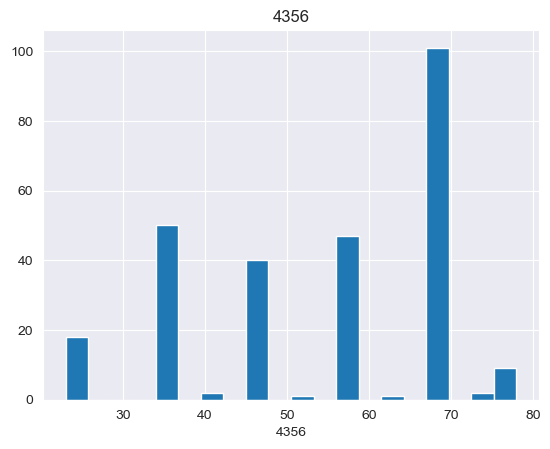

count   271.00000
mean     55.91882
std      14.45097
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      67.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      72.50000
99%      78.00000
max      78.00000
Name: 4357, dtype: float64


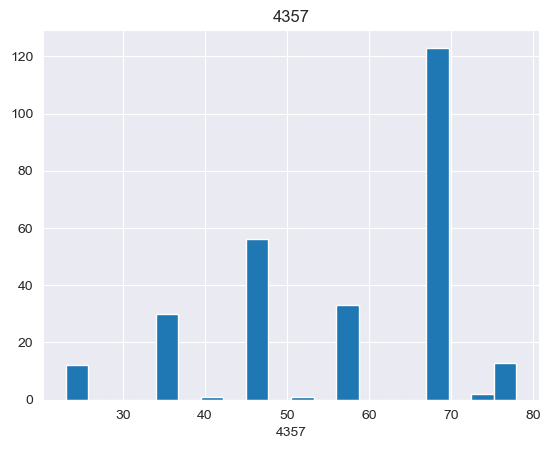

count   271.00000
mean     58.33395
std      16.39168
min       1.00000
5%       28.50000
10%      34.00000
20%      45.00000
30%      56.00000
40%      56.00000
50%      67.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      78.00000
95%      78.00000
99%      89.00000
max     100.00000
Name: 4407, dtype: float64


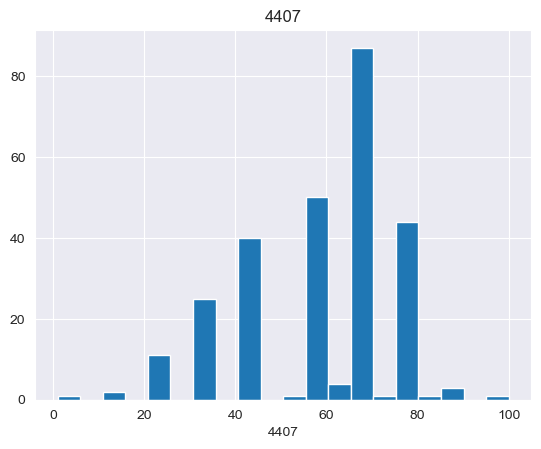

count   271.00000
mean     56.76445
std      15.33466
min      12.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      45.00000
40%      56.00000
50%      56.00000
60%      67.00000
70%      67.00000
80%      67.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4408, dtype: float64


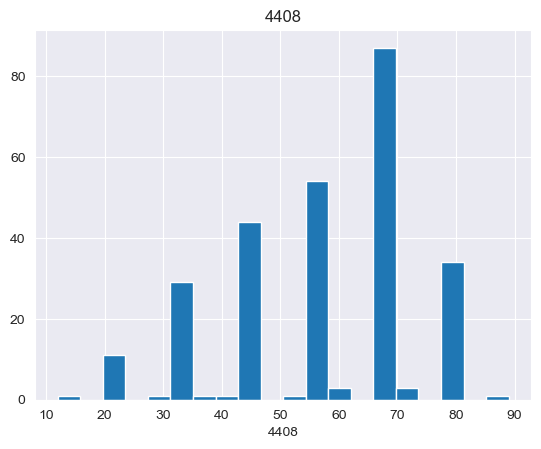

count   271.00000
mean     49.46494
std      16.21715
min      23.00000
5%       23.00000
10%      23.00000
20%      34.00000
30%      34.00000
40%      45.00000
50%      56.00000
60%      56.00000
70%      67.00000
80%      67.00000
90%      67.00000
95%      67.00000
99%      78.00000
max      78.00000
Name: 4423, dtype: float64


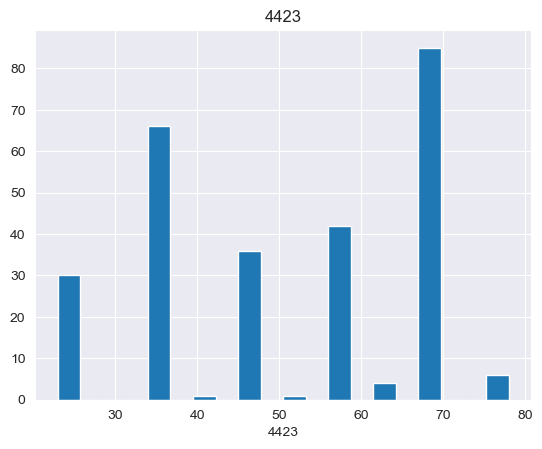

count   271.00000
mean     60.29582
std      17.02837
min      23.00000
5%       34.00000
10%      34.00000
20%      45.00000
30%      50.50000
40%      56.00000
50%      61.50000
60%      67.00000
70%      78.00000
80%      78.00000
90%      78.00000
95%      78.00000
99%      78.00000
max      89.00000
Name: 4426, dtype: float64


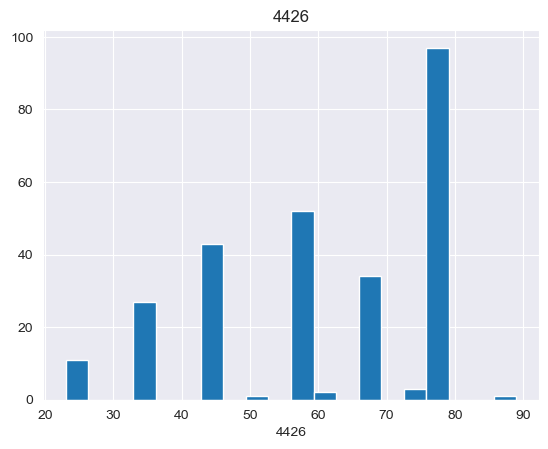

In [17]:
# Define a function to summarize numerical variables
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

# Summarize numerical columns
for col in num_cols:
    num_summary(pt, col, plot=True)

In [18]:
# Analyze the relationship between numerical features and the target variable
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
    
# Summarize numerical features with respect to the target
for col in num_cols:
    target_summary_with_num(pt, "potential_label", col)

attribute_id        4322
potential_label         
average         57.14264
highlighted     63.07143


attribute_id        4323
potential_label         
average         57.86744
highlighted     62.08929


attribute_id        4324
potential_label         
average         55.34341
highlighted     59.73214


attribute_id        4325
potential_label         
average         54.55891
highlighted     66.11607


attribute_id        4326
potential_label         
average         54.20930
highlighted     64.44643


attribute_id        4327
potential_label         
average         55.73566
highlighted     59.53571


attribute_id        4328
potential_label         
average         57.43256
highlighted     61.30357


attribute_id        4329
potential_label         
average         59.24031
highlighted     60.81250


attribute_id        4330
potential_label         
average         55.87209
highlighted     60.22321


attribute_id        4332
potential_label         
average         56.83566
highlig

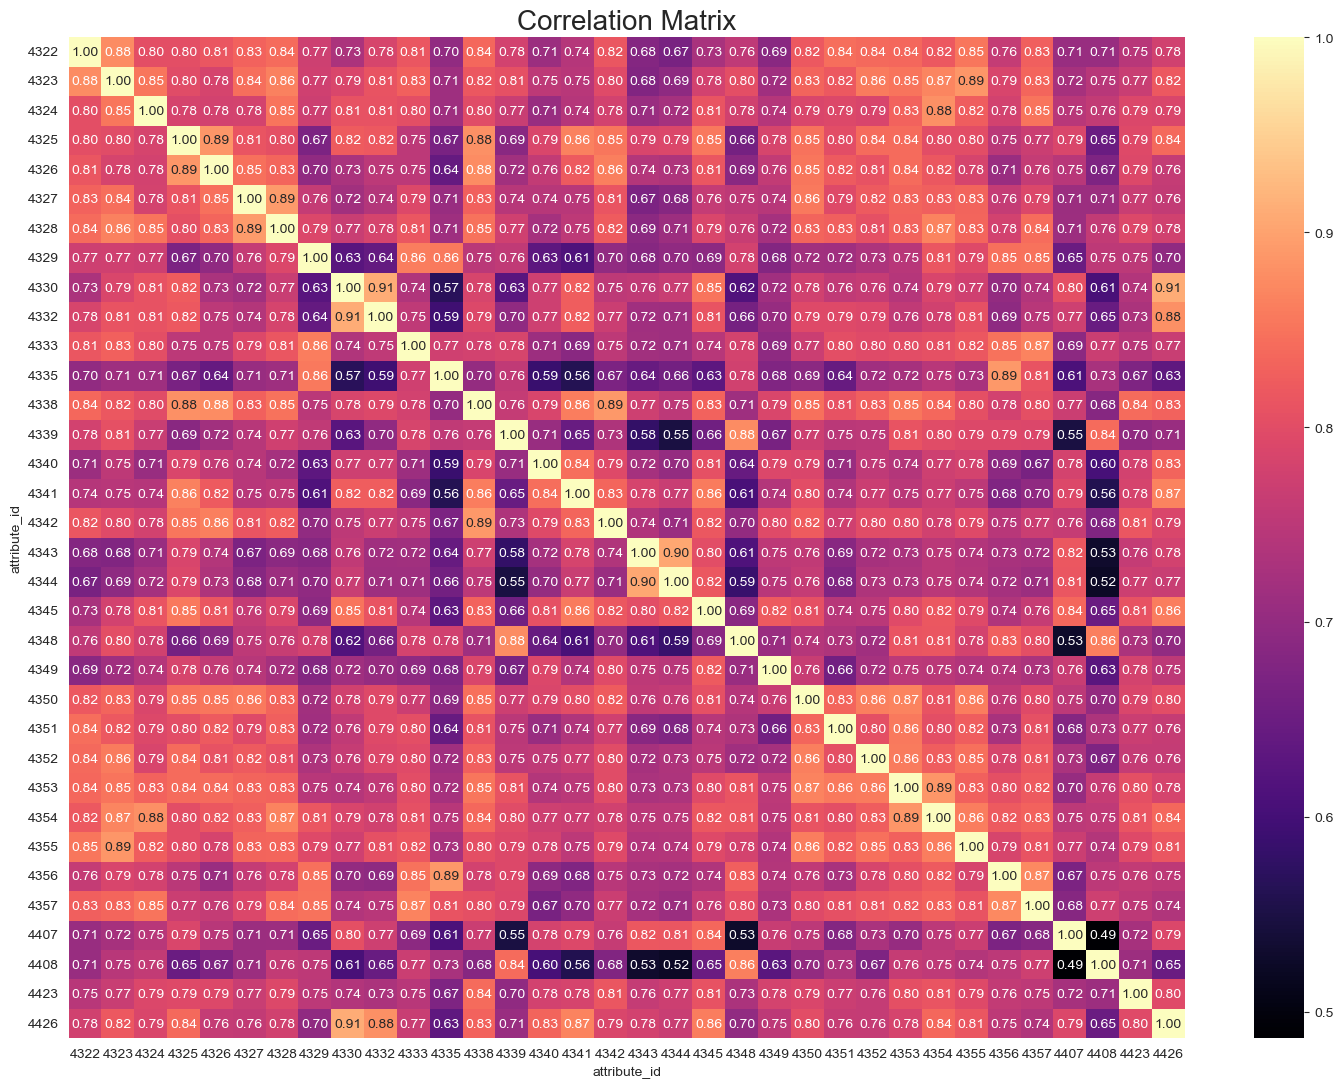

In [19]:
# Calculate and plot the correlation matrix for numerical features
correlation_matrix = pt[num_cols].corr()
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

In [21]:
# Split the data into training+validation and test sets
X = pt.drop(["potential_label", "player_id"], axis=1)
y = pt["potential_label"]
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train+validation into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [22]:
X_train.head()

attribute_id,position_id,4322,4323,4324,4325,4326,4327,4328,4329,4330,4332,4333,4335,4338,4339,4340,4341,4342,4343,4344,4345,4348,4349,4350,4351,4352,4353,4354,4355,4356,4357,4407,4408,4423,4426,mentality,min,max,sum,mean,median
44,9,56.00000,56.00000,34.00000,67.00000,56.00000,45.00000,56.00000,45.00000,56.00000,56.00000,56.00000,45.00000,56.00000,45.00000,45.00000,56.00000,56.00000,67.00000,56.00000,56.00000,34.00000,34.00000,56.00000,56.00000,56.00000,34.00000,45.00000,56.00000,56.00000,56.00000,56.00000,34.00000,34.00000,56.00000,attacker,34.00000,67.00000,1728.00000,50.82353,56.00000
201,8,67.00000,67.00000,78.00000,67.00000,67.00000,67.00000,67.00000,67.00000,78.00000,78.00000,56.00000,56.00000,67.00000,56.00000,67.00000,67.00000,67.00000,56.00000,56.00000,78.00000,56.00000,67.00000,78.00000,67.00000,67.00000,67.00000,78.00000,78.00000,56.00000,67.00000,89.00000,56.00000,56.00000,67.00000,attacker,56.00000,89.00000,2278.00000,67.00000,67.00000
170,6,45.00000,45.00000,45.00000,45.00000,34.00000,45.00000,45.00000,34.00000,45.00000,45.00000,45.00000,34.00000,45.00000,45.00000,45.00000,45.00000,45.00000,23.00000,12.00000,34.00000,34.00000,23.00000,45.00000,45.00000,45.00000,45.00000,45.00000,45.00000,34.00000,45.00000,34.00000,45.00000,34.00000,45.00000,attacker,12.00000,45.00000,1365.00000,40.14706,45.00000
245,2,56.00000,45.00000,45.00000,45.00000,56.00000,23.00000,45.00000,56.00000,56.00000,45.00000,45.00000,34.00000,56.00000,45.00000,23.00000,45.00000,45.00000,45.00000,23.00000,45.00000,45.00000,23.00000,45.00000,45.00000,45.00000,56.00000,56.00000,34.00000,34.00000,56.00000,34.00000,45.00000,34.00000,56.00000,defender,23.00000,56.00000,1486.00000,43.70588,45.00000
212,3,56.00000,56.00000,56.00000,45.00000,45.00000,56.00000,56.00000,56.00000,45.00000,45.00000,56.00000,34.00000,45.00000,45.00000,34.00000,45.00000,45.00000,23.00000,23.00000,56.00000,56.00000,34.00000,45.00000,56.00000,34.00000,45.00000,56.00000,45.00000,56.00000,45.00000,56.00000,45.00000,23.00000,56.00000,defender,23.00000,56.00000,1574.00000,46.29412,45.00000


In [23]:
# Define a function to apply label encoding to categorical variables
def label_encoder(train_df, val_df, test_df, binary_col):
    labelencoder = LabelEncoder()
    train_df[binary_col] = labelencoder.fit_transform(train_df[binary_col])
    val_df[binary_col] = labelencoder.transform(val_df[binary_col])
    test_df[binary_col] = labelencoder.transform(test_df[binary_col])
    return train_df, val_df, test_df

# Apply label encoding to 'mentality' feature
labelEncoderCols = ["mentality"]
for col in labelEncoderCols:
    X_train, X_val, X_test = label_encoder(X_train, X_val, X_test, col)

In [24]:
# Encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [25]:
# Update the list of numerical columns to include the calculated statistics
lst = ["min", "max", "sum", "mean", "median"]
num_cols = list(num_cols)
for i in lst:
    num_cols.append(i)

In [26]:
# Standardize numerical features
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [27]:
# Apply one-hot encoding to 'position_id' column
X_train = pd.get_dummies(X_train, columns=["position_id"], drop_first=True)
X_val = pd.get_dummies(X_val, columns=["position_id"], drop_first=True)
X_test = pd.get_dummies(X_test, columns=["position_id"], drop_first=True)

In [28]:
# Convert DataFrames to NumPy arrays for modeling
X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

In [29]:
# Define and evaluate multiple classification models
models = [('LR', LogisticRegression()),
          ('KNN', KNeighborsClassifier()),
          ("SVC", SVC(probability=True)),
          ("CART", DecisionTreeClassifier()),
          ("RF", RandomForestClassifier()),
          ('Adaboost', AdaBoostClassifier()),
          ('GBM', GradientBoostingClassifier()),
          ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
          ('CatBoost', CatBoostClassifier(verbose=False))]

# Evaluate each model on the validation set
for name, model in models:
    print(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    for score in ["roc_auc", "f1", "precision", "recall", "accuracy"]:
        if score == "roc_auc":
            score_value = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])
        elif score == "f1":
            score_value = f1_score(y_val, y_pred)
        elif score == "precision":
            score_value = precision_score(y_val, y_pred, zero_division=0)
        elif score == "recall":
            score_value = recall_score(y_val, y_pred)
        else:  # accuracy
            score_value = accuracy_score(y_val, y_pred)
        print(f"{score} score: {score_value:.4f}")
    print("\n")

LR
roc_auc score: 0.8893
f1 score: 0.8182
precision score: 1.0000
recall score: 0.6923
accuracy score: 0.9259


KNN
roc_auc score: 0.8114
f1 score: 0.4444
precision score: 0.8000
recall score: 0.3077
accuracy score: 0.8148


SVC
roc_auc score: 0.9550
f1 score: 0.1429
precision score: 1.0000
recall score: 0.0769
accuracy score: 0.7778


CART
roc_auc score: 0.8377
f1 score: 0.7097
precision score: 0.6111
recall score: 0.8462
accuracy score: 0.8333


RF
roc_auc score: 0.9456
f1 score: 0.7273
precision score: 0.8889
recall score: 0.6154
accuracy score: 0.8889


Adaboost
roc_auc score: 0.9362
f1 score: 0.6667
precision score: 0.7273
recall score: 0.6154
accuracy score: 0.8519


GBM
roc_auc score: 0.9306
f1 score: 0.6364
precision score: 0.7778
recall score: 0.5385
accuracy score: 0.8519


XGBoost
roc_auc score: 0.9381
f1 score: 0.6957
precision score: 0.8000
recall score: 0.6154
accuracy score: 0.8704


CatBoost
roc_auc score: 0.9587
f1 score: 0.7000
precision score: 1.0000
recall score: 0.

In [30]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'depth': [6, 8, 10],                   # Range of tree depths to test
    'learning_rate': [0.01, 0.1, 0.3],     # Different learning rates to evaluate
    'iterations': [100, 200, 300],         # Number of boosting iterations
    'l2_leaf_reg': [1, 3, 5]               # Regularization strengths to consider
}

# Initialize the CatBoostClassifier without setting specific parameters initially
catboost = CatBoostClassifier(verbose=0)  


# Set up GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=catboost,
                           param_grid=param_grid,       # The grid of parameters to test
                           scoring='roc_auc',           # Use ROC AUC as the evaluation metric
                           cv=3,                        # Perform 3-fold cross-validation
                           n_jobs=-1,                   # Utilize all available cores for computation
                           verbose=1)                 

# Fit GridSearchCV to the validation data
grid_search.fit(X_val, y_val)

# Display the best found parameters and the corresponding best score
print("Best parameters found: ", grid_search.best_params_)
print("Best ROC AUC score found: ", grid_search.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters found:  {'depth': 10, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
Best ROC AUC score found:  0.9283882783882785


In [31]:
# Initialize CatBoostClassifier using the best parameters from GridSearchCV
catboost = CatBoostClassifier(
    depth=10,               # Set to the best depth found
    iterations=100,         # Set to the best number of iterations found
    l2_leaf_reg=1,          # Set to the best regularization found
    learning_rate=0.01,     # Set to the best learning rate found
    verbose=1           
)

# Fit the model to the training data with the selected parameters
catboost.fit(X_train, y_train, eval_set=(X_test, y_test))

# Predict labels and probabilities on the test set
y_test_pred = catboost.predict(X_test)
y_test_proba = catboost.predict_proba(X_test)[:, 1]

# Print evaluation metrics for the test set
print("Test Set:")
print(f"ROC AUC score: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"F1 score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision score: {precision_score(y_test, y_test_pred, zero_division=0):.4f}")
print(f"Recall score: {recall_score(y_test, y_test_pred):.4f}")
print(f"Accuracy score: {accuracy_score(y_test, y_test_pred):.4f}")

0:	learn: 0.6836619	test: 0.6870081	best: 0.6870081 (0)	total: 2.23ms	remaining: 220ms
1:	learn: 0.6721485	test: 0.6780271	best: 0.6780271 (1)	total: 4.37ms	remaining: 214ms
2:	learn: 0.6623706	test: 0.6712571	best: 0.6712571 (2)	total: 6.23ms	remaining: 202ms
3:	learn: 0.6491552	test: 0.6597936	best: 0.6597936 (3)	total: 8.25ms	remaining: 198ms
4:	learn: 0.6365025	test: 0.6505187	best: 0.6505187 (4)	total: 9.37ms	remaining: 178ms
5:	learn: 0.6281819	test: 0.6466828	best: 0.6466828 (5)	total: 11ms	remaining: 173ms
6:	learn: 0.6186980	test: 0.6400108	best: 0.6400108 (6)	total: 12.9ms	remaining: 171ms
7:	learn: 0.6105145	test: 0.6329428	best: 0.6329428 (7)	total: 13.5ms	remaining: 155ms
8:	learn: 0.6029348	test: 0.6286030	best: 0.6286030 (8)	total: 15.2ms	remaining: 153ms
9:	learn: 0.5918509	test: 0.6208594	best: 0.6208594 (9)	total: 17.1ms	remaining: 154ms
10:	learn: 0.5885494	test: 0.6175758	best: 0.6175758 (10)	total: 17.4ms	remaining: 141ms
11:	learn: 0.5811111	test: 0.6135843	best: 